In [1]:
# ========================================
# Instalación de dependencias
# ========================================
!pip install medmnist
!pip install torchvision torch matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.7 MB/s eta 0:00:00


In [2]:
# ========================================
# Carga de librerías
# ========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
# ========================================
# Verificación de GPU
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))
else:
    print("Usando CPU")


GPU disponible: True
Dispositivo: Tesla T4


In [4]:
# ========================================
# Configuración y Dataset PathMNIST
# ========================================

# Dataset info
data_flag = 'pathmnist'
info = INFO[data_flag]
task = info['task']
n_classes = len(info['label'])

# Transformaciones (mejora con Data Augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Descarga de datasets
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset   = DataClass(split='val', transform=test_transform, download=True)
test_dataset  = DataClass(split='test', transform=test_transform, download=True)

# Loaders
batch_size = 32  #reducido para velocidad
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 206M/206M [00:10<00:00, 20.1MB/s]


In [5]:
# ========================================
# Definición del Modelo (EfficientNet-B0)
# ========================================

# Cargar modelo preentrenado
model = models.efficientnet_b0(pretrained=True)

# Reemplazar la última capa por nuestro número de clases
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, n_classes)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


In [6]:
# ========================================
# Función de pérdida y Optimizador
# ========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [7]:
# ========================================
# Entrenamiento del modelo
# ========================================
epochs = 2  #Épocas

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    val_acc, val_loss = 0, 0

    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_acc = 100. * correct / total

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f} "
          f"Val Acc: {val_acc:.2f}%")


Epoch 1/2: 100%|██████████| 2813/2813 [11:17<00:00,  4.15it/s]


Epoch [1/2] Train Loss: 0.1866 Train Acc: 93.89% | Val Loss: 0.1252 Val Acc: 96.20%


Epoch 2/2: 100%|██████████| 2813/2813 [11:15<00:00,  4.16it/s]


Epoch [2/2] Train Loss: 0.0960 Train Acc: 96.89% | Val Loss: 0.0949 Val Acc: 98.29%


In [11]:
# ========================================
# Evaluación en Test Set
# ========================================
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Precisión en Test Set: {test_acc:.2f}%")


Precisión en Test Set: 90.24%


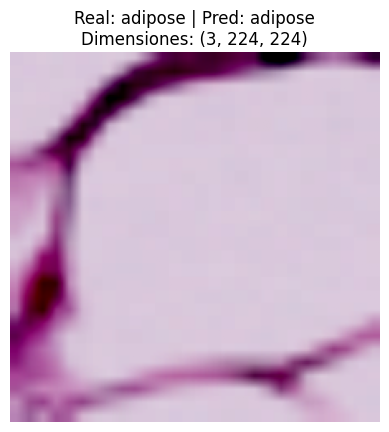

In [16]:
# ========================================
# Mostrar una predicción de ejemplo con dimensiones
# ========================================

# Obtener una muestra del test set
sample_img, sample_label = test_dataset[232]  # puedes cambiar el índice | 900 esta mal
sample_img_tensor = sample_img.unsqueeze(0).to(device)  # añadir batch dim

# Predicción
model.eval()
with torch.no_grad():
    output = model(sample_img_tensor)
    pred_class = torch.argmax(output, 1).item()

# Diccionario de etiquetas
label_dict = info['label']

# Mostrar imagen con etiqueta real, predicción y dimensiones
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title(f"Real: {label_dict[str(sample_label.item())]} | "
          f"Pred: {label_dict[str(pred_class)]}\n"
          f"Dimensiones: {sample_img.numpy().shape}")
plt.show()


Accuracy en Test Set: 90.24%
F1-score (macro): 0.8483
F1-score (weighted): 0.8978


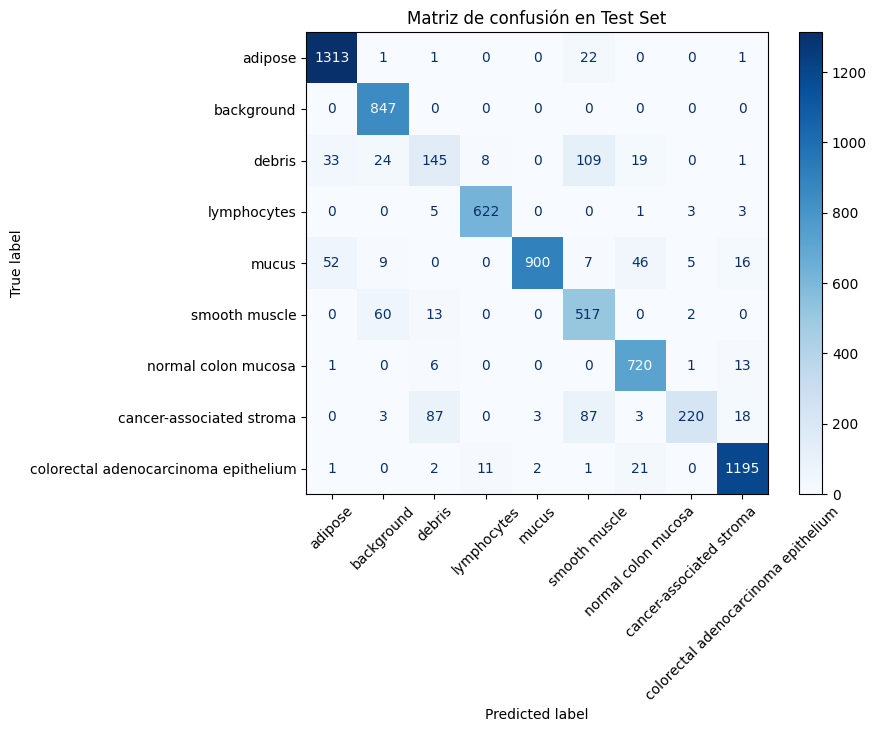

In [17]:
# ========================================
# Evaluación en Test Set con métricas extra
# ========================================
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
test_acc = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy en Test Set: {test_acc:.2f}%")

# F1-score (macro y weighted)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(info["label"].values()))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de confusión en Test Set")
plt.show()